### To do
- faire une PCA

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, auc, confusion_matrix

#### Retrait des colonnes et lignes inutiles / sélection de features

In [2]:
# load data
raw = pd.read_excel('data/dataframe_elections.xlsx')
print('Taille initiale du DF :', raw.shape)

# Données d'identification
id_list = ['an', 'code', 'nom', 'prenom', 'nuance_groupe', 'taux_vote_leg', 'second_tour']
df_id = raw[id_list]

# drop colonnes
drop_list = ['dep', 'circo', 'code', 'inscrits', 'circo_parti', 'circo_nuance',
             'nom', 'prenom', 'etiquette', 'nuance', 'voix', 'second_tour']
raw = raw.drop(drop_list, axis=1)

print('Taille du DF après retrait des colonnes inutiles :', raw.shape)

Taille initiale du DF : (36919, 79)
Taille du DF après retrait des colonnes inutiles : (36919, 67)


### Feature engineering

In [3]:
# à garder obligatoirement pour identifier les lignes et créer les labels
keep_list = ['an', 'c_dep', 'nuance_groupe', 'p_inscrits', 'p_exprimes']

# Sélection des features
keep_list.extend([#'geo_frontalier', 'geo_dom', 'geo_idf',
                  'part_impose', 'chom_tot',
                  #'p_agri', 'p_ouvriers', 'd_brevet','d_sup',
                  'circo_leg_meme_nuance', 'circo_meme_nuance_president', 'circo_pres_meme_nuance',
                  'nb_candidats_meme_bloc', 'score_nuance_groupe_pres', 'score_candidat_prec_leg',
                  #'score_nuance_groupe_prec_leg', #(un peu mauvais)
                  #'score_bloc_pres', 'score_bloc_prec_leg', #(mauvais pour le score)
                  #'nuance_groupe',
                  'taux_vote_pres', 'taux_vote_leg',
                  'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre',
                  'membre_majorite', 'sexe'
    ])

df = raw.drop([col for col in raw.columns if col not in keep_list], axis=1)
print(df.columns)

# Gestion des NaN au niveau du score du candidat aux législatives précédentes
years = [2002, 2007, 2012, 2017]

# TODO : POUR LES CANDIDATS "EN MARCHE", PAR QUOI REMPLIR LE SCORE DES CANDIDATS A LA PREC LEG ?

partis = ['EXG', 'COM', 'FI', 'DVG', 'ECO', 'SOC', 'RDG', 'MDM',
          'UDI', 'DVD', 'LR', 'DLF', 'FN', 'EXD', 'REG', 'DIV']
for parti in partis:
    #print('\nRemplissage des valeurs manquantes pour {} :'.format(parti))
    for year in years:
        mask = (df['an']==year) & (df['nuance_groupe']==parti)
        mask_2 = (df['an']==year - 5) & (df['nuance_groupe']==parti)
        mean = np.mean(df['p_inscrits'][mask_2]) # moyenne des voix du parti 5 ans avant
        df.loc[mask, 'score_candidat_prec_leg'] = df['score_candidat_prec_leg'][mask].fillna(value=mean)
        #print('La moyenne du parti en {} est {:.2f}%'.format(year - 5, mean * 100))

mean = np.mean(df.p_inscrits)
print('\nRemplissage des dernières valeurs manquantes pour la législative précédente avec {:.2f}%'.format(mean * 100))
df.score_candidat_prec_leg = df.score_candidat_prec_leg.fillna(value=mean)

# Gestion des NaN : Autres variables. Remplacement des valeurs manquantes par la moyenne nationale
features_a_completer = ['chom_tot']
for feature in features_a_completer:
    print('\nRemplissage des valeurs manquantes pour {} :'.format(feature))
    for year in years:
        mask = (df['an']==year)
        mean = np.mean(df[feature][mask])
        print('La moyenne de la feature pour {} est {:.2f}%'.format(year, mean * 100))
        df.loc[mask, feature] = df[feature][mask].fillna(value=mean)
        
# Normaliser les votes


# Catégorisation
# df['score_candidat_prec_leg'] = pd.cut(df['score_candidat_prec_leg'], bins=[-1, -.01, .05, .1, .15, .2, 1],
#                                       labels=['N/A', 'A', 'B', 'C', 'D', 'E'])

# On retire les lignes de 1997
df = df[df.an > 1997]
df = df[df.nuance_groupe!='DIV']
df = df.drop(['c_dep', 'nuance_groupe'], axis=1)

Index(['an', 'c_dep', 'part_impose', 'chom_tot', 'circo_leg_meme_nuance',
       'nb_candidats_meme_bloc', 'taux_vote_leg', 'circo_pres_meme_nuance',
       'circo_meme_nuance_president', 'score_nuance_groupe_pres',
       'taux_vote_pres', 'score_candidat_prec_leg', 'depute_sortant',
       'ancien_depute', 'au_gouvernement', 'ancien_ministre',
       'membre_majorite', 'sexe', 'nuance_groupe', 'p_inscrits', 'p_exprimes'],
      dtype='object')

Remplissage des dernières valeurs manquantes pour la législative précédente avec 4.82%

Remplissage des valeurs manquantes pour chom_tot :
La moyenne de la feature pour 2002 est 8.05%
La moyenne de la feature pour 2007 est 8.97%
La moyenne de la feature pour 2012 est 9.54%
La moyenne de la feature pour 2017 est 9.43%


In [4]:
print(df.shape)
print(df.isnull().sum())

(26396, 19)
an                                0
part_impose                       0
chom_tot                          0
circo_leg_meme_nuance             0
nb_candidats_meme_bloc            0
taux_vote_leg                     0
circo_pres_meme_nuance            0
circo_meme_nuance_president       0
score_nuance_groupe_pres          0
taux_vote_pres                    0
score_candidat_prec_leg           0
depute_sortant                    0
ancien_depute                     0
au_gouvernement                   0
ancien_ministre                   0
membre_majorite                   0
sexe                              0
p_inscrits                     6463
p_exprimes                     6463
dtype: int64


#### Création des ensembles de train/validation/test

In [5]:
def train_val_splits(df, year_for_validation, target='p_exprimes'):
    drop_list = ['an', 'p_inscrits', 'p_exprimes']
    df_train = df[(df.an != 2017) & (df.an != year_for_validation)].dropna(how='any')
    y_train = df_train[target]
    X_train = df_train.drop(drop_list, axis=1)
    
    df_val = df[df.an == year_for_validation].dropna(how='any')
    y_val = df_val[target]
    X_val = df_val.drop(drop_list, axis=1)
    
    return X_train, X_val, y_train, y_val

In [6]:
# Liste des variables dummies et binaires pour les exclure de la normalisation
dummies_list = ['bloc', 'sexe', 'an', 'p_inscrits', 'p_exprimes',
                #'geo_frontalier', 'geo_dom', 'geo_idf',
                'circo_nuance_groupe', 'circo_bloc', 'nuance_groupe',
                'circo_nuance_groupe_pres', 'circo_pres_meme_nuance', 'circo_meme_nuance_president',
                'circo_leg_meme_nuance',
                'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre', 'membre_majorite',
                'nb_candidats_meme_bloc', 'score_candidat_prec_leg']
scale_list = [col for col in df.columns if col not in dummies_list]

# Choix de la cible (prédire en % des voix exprimées ou en % des inscrits)
target = 'p_exprimes'
# target = 'p_inscrits'

print('Variables à normaliser', scale_list)
df_dummified = pd.get_dummies(df, drop_first=True)
X_train, X_val, y_train, y_val = train_val_splits(df_dummified, 2012, target=target)

# Normalisation du dataframe
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train[scale_list] = scaler.fit_transform(X_train[scale_list])
X_val[scale_list] = scaler.transform(X_val[scale_list])

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

Variables à normaliser ['part_impose', 'chom_tot', 'taux_vote_leg', 'score_nuance_groupe_pres', 'taux_vote_pres']
(13788, 16) (6145, 16)
(13788,) (6145,)


#### Exploration

In [7]:
X_train.head(5)

,part_impose,chom_tot,circo_leg_meme_nuance,nb_candidats_meme_bloc,taux_vote_leg,circo_pres_meme_nuance,circo_meme_nuance_president,score_nuance_groupe_pres,taux_vote_pres,score_candidat_prec_leg,depute_sortant,ancien_depute,au_gouvernement,ancien_ministre,membre_majorite,sexe_M
14488,0.546669,0.061475,0.0,3.0,0.651274,0.0,0.0,0.018692,0.940721,0.036679,0.0,0.0,0.0,0.0,0.0,1
14489,0.546669,0.061475,1.0,2.0,0.651274,1.0,0.0,0.481142,0.940721,0.223836,0.0,0.0,0.0,0.0,1.0,1
14490,0.546669,0.061475,0.0,1.0,0.651274,0.0,0.0,0.157710,0.940721,0.070266,0.0,0.0,0.0,0.0,0.0,0
14491,0.546669,0.061475,0.0,3.0,0.651274,0.0,0.0,0.326268,0.940721,0.184033,0.0,0.0,0.0,0.0,0.0,1
14492,0.546669,0.061475,0.0,3.0,0.651274,0.0,0.0,0.043224,0.940721,0.014068,0.0,0.0,0.0,0.0,0.0,0


#### Choix de modèle

In [19]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1, n_estimators=500)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [9]:
# from sklearn.svm import SVR
# reg = SVR()
# reg.fit(X_train, y_train)
# y_pred = reg.predict(X_val)

### Analyser les prédictions

In [20]:
def get_predictions(y_pred, y_val, id_val, target='p_exprimes'):
    from scipy.stats import rankdata
    res = pd.concat([id_val, pd.DataFrame(y_val)], axis=1, join='inner')
    res['prediction'] = y_pred
    res['ecart'] = y_pred - res[target]
    res['classement'] = 0
    res['qualif'] = 'N'
    
    for circo in set(res.code):
        # classement des candidats par circonscription
        res.loc[res.code==circo, 'classement'] = rankdata(-res.prediction[res.code==circo], method='ordinal')
        if target=='p_exprimes':
            taux_E = 1
            taux_O = np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
        elif target=='p_inscrits':
            taux_E = 1 / np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
            taux_O = 1
            
        # simulation des qualifiés pour le second tour
        i = 1
        q = 0
        while True:
            #print(res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values)
            if (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_E >= .5:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'E'
                break
            elif (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_O >= .125:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            elif q < 2:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            else:
                break

            i += 1
    return res

In [21]:
sorted(list(zip(rf.feature_importances_*100, X_train.columns)), reverse=True)

[(74.438124306263845, 'score_candidat_prec_leg'),
 (7.413861235652262, 'score_nuance_groupe_pres'),
 (5.0046441642294814, 'depute_sortant'),
 (2.627721854404653, 'membre_majorite'),
 (1.9885190696463537, 'taux_vote_pres'),
 (1.8234585344204075, 'taux_vote_leg'),
 (1.5461488967638874, 'part_impose'),
 (1.4201298925018375, 'chom_tot'),
 (1.2111954166288161, 'nb_candidats_meme_bloc'),
 (1.0270732515639787, 'circo_leg_meme_nuance'),
 (0.62404665793452574, 'circo_pres_meme_nuance'),
 (0.4290872826257866, 'ancien_depute'),
 (0.42593463162914069, 'sexe_M'),
 (0.013834720567089672, 'ancien_ministre'),
 (0.0062200851679746769, 'au_gouvernement'),
 (0.0, 'circo_meme_nuance_president')]

Prédictions pour 6145 candidats.
La MAE est : 3.64%
La plus grosse erreur est : 53.04%
Le score AUC est : 49.35%


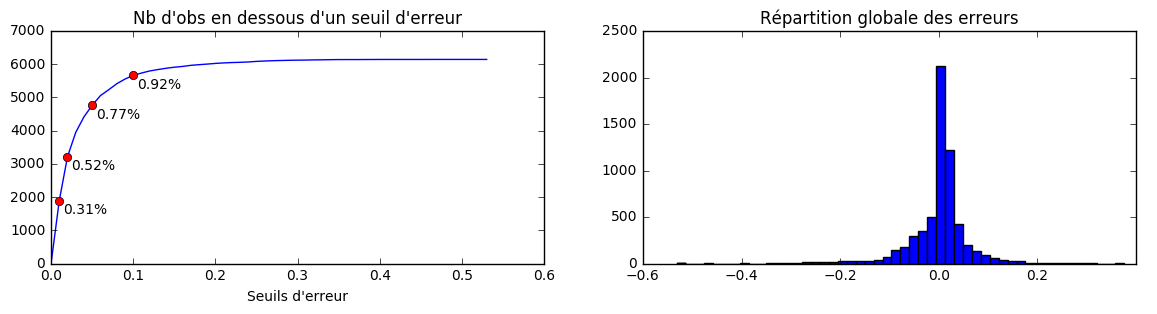

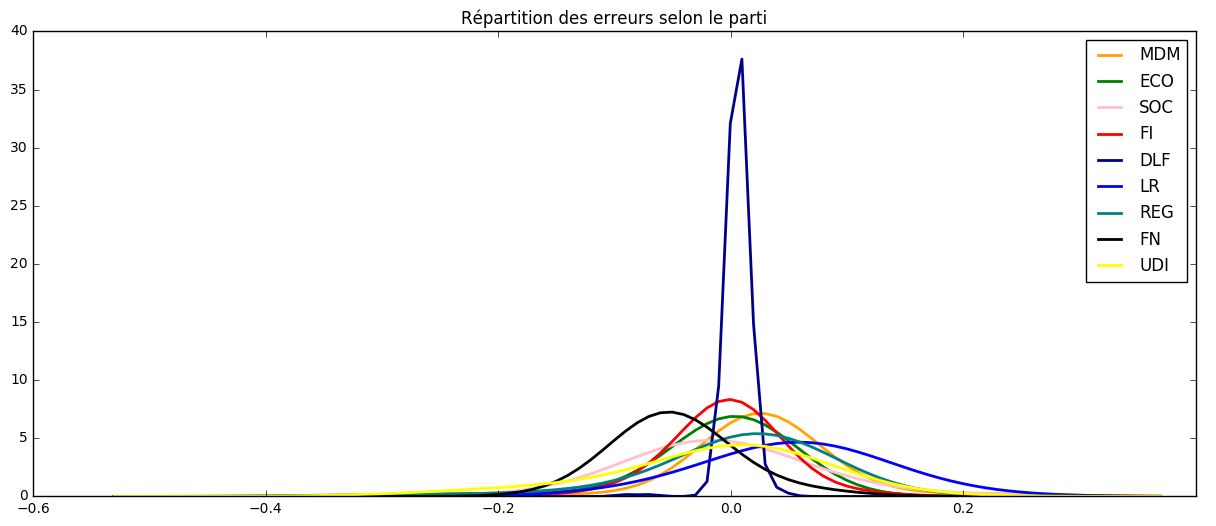

In [22]:
df_predictions = get_predictions(y_pred, y_val, df_id, target=target)
n = df_predictions.shape[0]
print('Prédictions pour {} candidats.'.format(n))

ecarts_absolus = abs(df_predictions['ecart'])
max_ecart = np.max(ecarts_absolus)
grid = np.arange(max_ecart, step=.01)
ecarts_grid = []

for point in grid:
    ecarts_grid.append(np.sum(ecarts_absolus < point))

print('La MAE est : {:.2f}%'.format(mean_absolute_error(y_val, y_pred) * 100))
print('La plus grosse erreur est : {:.2f}%'.format(max_ecart * 100))
print('Le score AUC est : {:.2f}%'.format(auc(grid, ecarts_grid) * 100 / n))

point_list = [.01, .02, .05, .1]
ecart_list = [np.sum(ecarts_absolus < point) for point in point_list]

plt.figure(1, figsize=(14, 3))
plt.subplot(121)
plt.plot(grid, ecarts_grid)
for i in range(len(point_list)):
    plt.plot(point_list[i], ecart_list[i], 'ro')
    plt.text(point_list[i]+.005, ecart_list[i]-400, '{:.2f}%'.format(ecart_list[i]/n))

plt.title('Nb d\'obs en dessous d\'un seuil d\'erreur')
plt.xlabel('Seuils d\'erreur')
    
plt.subplot(122)
plt.hist(df_predictions['ecart'], bins=50)
plt.title('Répartition globale des erreurs')

# comparaison de la distribution des erreurs, parti par parti
from scipy.stats import gaussian_kde
plt.figure(2, figsize=(15,6))
x_grid = np.arange(min(df_predictions['ecart']), max(df_predictions['ecart']), step=.01)

nuances = {'FI': 'red','ECO': 'green', 'SOC': 'pink', 'MDM': 'orange', 'UDI': 'yellow',
           'LR': 'blue', 'DLF': 'darkblue', 'FN': 'black', 'REG': 'teal'}
for nuance in nuances:
    n_nuance = np.sum(df_predictions['nuance_groupe']==nuance)
    pdf = gaussian_kde(df_predictions['ecart'][df_predictions['nuance_groupe']==nuance],
                       bw_method=.9).evaluate(x_grid)
    plt.plot(x_grid, pdf, color=nuances[nuance], label=nuance, lw=2)

plt.title('Répartition des erreurs selon le parti')
plt.legend(loc='best')

plt.show()

In [24]:
print('{} prédictions correctes sur {}'.format(np.sum(df_predictions.second_tour == df_predictions.qualif), n))
print('Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.')
confusion_matrix(df_predictions.second_tour, df_predictions.qualif, labels=['E', 'O', 'N'])

5721 prédictions correctes sur 6145
Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.


array([[   3,   33,    0],
       [   9,  916,  176],
       [   0,  206, 4802]])

In [25]:
df_predictions.sort_values(by='ecart').tail(5)

,an,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,ecart,classement,qualif
14299,2012,986|1,VANAI,SIMIONE,SOC,0.7722,N,0.0926,0.374664,0.282064,2,O
11034,2012,974|7,LASSON,JEAN-MARIE,SOC,0.4331,N,0.1124,0.399753,0.287353,1,O
10672,2012,35|7,CLEMENT,PASCAL,FN,0.5933,N,0.0753,0.382607,0.307307,2,O
10518,2012,34|3,GRAND,JEAN-PIERRE,LR,0.6206,O,0.1734,0.488716,0.315316,1,O
10990,2012,974|2,LOUGNON,LAURENCE,SOC,0.4562,N,0.0305,0.405398,0.374898,1,O


In [26]:
df_predictions.sort_values(by='ecart').head(5)

,an,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,ecart,classement,qualif
13113,2012,975|1,GIRARDIN,ANNICK,RDG,0.5186,E,0.6552,0.124758,-0.530442,2,O
12340,2012,75|6,DUFLOT,CECILE,ECO,0.5929,O,0.4874,0.029145,-0.458255,9,N
12414,2012,75|10,BAUPIN,DENIS,ECO,0.5834,O,0.4289,0.029754,-0.399146,9,N
10982,2012,974|2,BELLO,HUGUETTE,DVG,0.4562,E,0.6712,0.284889,-0.386311,2,O
10882,2012,38|9,BONNETON,MICHELE,ECO,0.5691,O,0.3718,0.024825,-0.346975,7,N


In [33]:
from datetime import datetime
now = datetime.now()
stamp = '{}_{}_{}h{}'.format(now.day, now.month, now.hour, now.minute)
df_predictions.to_excel('predictions_du_{}.xlsx'.format(stamp))